In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import pydicom
import SimpleITK as sitk

import torch

import os
from pathlib import Path
import yaml
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
with open('config.yaml', "r") as file:
    config = yaml.safe_load(file)

ROOT_DATA_DIR = Path(config["ROOT_DATA_DIR"]).expanduser().absolute()
DATA_DIR = os.path.join(ROOT_DATA_DIR,'data')
LABELS_PATH = os.path.join(ROOT_DATA_DIR,'train.csv')

In [4]:
file_path = os.path.join(DATA_DIR,'1.3.46.670589.11.10042.5.0.1412.2024020313391873234')

series_file_name = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(file_path)
volume = sitk.ReadImage(series_file_name, sitk.sitkInt32)
volume_intensity = sitk.GetArrayFromImage(volume)

print(f'size: {volume_intensity.size}\nshape: {volume_intensity.shape}\nmin value: {volume_intensity.min()}\nmax value: {volume_intensity.max()}')

size: 1327104
shape: (16, 288, 288)
min value: 0
max value: 748


# Extract Data

## Intensity Data

In [ ]:
import os
import SimpleITK as sitk
from tqdm import tqdm

def extract_intensity_data(directory_path):
    intensity_data = []

    file_paths = [os.path.join(directory_path, file_name) for file_name in os.listdir(directory_path)]

    for file_path in tqdm(file_paths, desc="Processing DICOM files"):
        dicom_series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(file_path)
        
        if dicom_series_file_names:
            image_volume = sitk.ReadImage(dicom_series_file_names, sitk.sitkInt32)
            volume_array = sitk.GetArrayFromImage(image_volume)
            
            intensity_data.append({
                'file_path': file_path,
                'size': volume_array.size,
                'shape': volume_array.shape,
                'min_value': volume_array.min(),
                'max_value': volume_array.max()
            })
                        
    return intensity_data

intensity_values = extract_intensity_data(DATA_DIR)
intensity_df = pd.DataFrame(intensity_values)
intensity_df.to_csv("intensity_values.csv", index=False)

## MetaData

In [ ]:
import os
import pydicom
import SimpleITK as sitk
from tqdm import tqdm

def extract_meta_data(directory_path):
    meta_data = []
    file_paths = [os.path.join(directory_path, file_name) for file_name in os.listdir(directory_path)]
    
    for file_path in tqdm(file_paths, desc="Processing files"):
        try:
            dicom_series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(file_path)
            if dicom_series_file_names:  
                for serie in dicom_series_file_names:
                    header = pydicom.dcmread(str(serie), stop_before_pixels=True)
                    meta_data.append({elem.keyword: elem.value for elem in header if elem.keyword})
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
        
    return meta_data

metadata = extract_meta_data(DATA_DIR)
metadata_df = pd.DataFrame(metadata)
metadata_df.to_csv("metadata.csv", index=False)

# Import Extracted data

In [5]:
intensity_df = pd.read_csv("intensity_values.csv")
intensity_df.head(3)

,file_path,size,shape,min_value,max_value
0,/kaggle/input/iaaa-mri-challenge/data/1.3.46.6...,1048576,"(16, 256, 256)",0,1032
1,/kaggle/input/iaaa-mri-challenge/data/1.3.46.6...,1492992,"(18, 288, 288)",0,538
2,/kaggle/input/iaaa-mri-challenge/data/1.3.46.6...,1492992,"(18, 288, 288)",0,474


In [6]:
metadata_df = pd .read_csv("metadata.csv")
metadata_df.head(3)

,SpecificCharacterSet,ImageType,InstanceCreationDate,InstanceCreationTime,InstanceCreatorUID,SOPClassUID,SOPInstanceUID,StudyDate,SeriesDate,AcquisitionDate,ContentDate,StudyTime,SeriesTime,AcquisitionTime,ContentTime,AccessionNumber,Modality,Manufacturer,InstitutionName,ReferringPhysicianName,CodeValue,CodingSchemeDesignator,CodeMeaning,StationName,StudyDescription,SeriesDescription,InstitutionalDepartmentName,OperatorsName,AdmittingDiagnosesDescription,ManufacturerModelName,ReferencedPerformedProcedureStepSequence,ReferencedImageSequence,PatientName,PatientID,PatientBirthDate,PatientSex,OtherPatientIDs,PatientWeight,PregnancyStatus,DeidentificationMethodCodeSequence,BodyPartExamined,ScanningSequence,SequenceVariant,ScanOptions,MRAcquisitionType,SequenceName,SliceThickness,RepetitionTime,EchoTime,NumberOfAverages,ImagingFrequency,ImagedNucleus,EchoNumbers,MagneticFieldStrength,SpacingBetweenSlices,NumberOfPhaseEncodingSteps,EchoTrainLength,PercentSampling,PercentPhaseFieldOfView,PixelBandwidth,DeviceSerialNumber,SoftwareVersions,ProtocolName,LowRRValue,HighRRValue,IntervalsAcquired,IntervalsRejected,HeartRate,ReconstructionDiameter,ReceiveCoilName,TransmitCoilName,AcquisitionMatrix,InPlanePhaseEncodingDirection,FlipAngle,SAR,dBdt,PatientPosition,AcquisitionDuration,DiffusionBValue,DiffusionGradientOrientation,StudyInstanceUID,SeriesInstanceUID,StudyID,SeriesNumber,AcquisitionNumber,InstanceNumber,ImagePositionPatient,ImageOrientationPatient,FrameOfReferenceUID,TemporalPositionIdentifier,NumberOfTemporalPositions,PositionReferenceIndicator,SliceLocation,SamplesPerPixel,PhotometricInterpretation,NumberOfFrames,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,LossyImageCompression,StudyComments,ScheduledPerformingPhysicianName,PerformedStationAETitle,PerformedProcedureStepStartDate,PerformedProcedureStepStartTime,PerformedProcedureStepEndDate,PerformedProcedureStepEndTime,PerformedProcedureStepID,PerformedProcedureStepDescription,CommentsOnThePerformedProcedureStep,FilmConsumptionSequence,RealWorldValueMappingSequence,PresentationLUTShape,PerformedProtocolCodeSequence,InversionTime
0,ISO_IR 100,"['ORIGINAL', 'PRIMARY', 'M_SE', 'M', 'SE']",20240211,124116,1.3.46.670589.11.10042.5,1.2.840.10008.5.1.4.1.1.4,1.2.826.0.1.3680043.8.498.38198043203030920396...,20240210,20240210,20240210,20240210,92316,93557.79,93557.79,93557.79,NaN,MR,Philips Medical Systems,Sepahan Medical Imaging Center,anonymous,NaN,DCM,NaN,PHILIPS-A9DD1E7,MRI_Labeling_normal_abnormal_SPI_p5,T1W_SE,MRI,anonymous,NaN,Achieva,"[(0008, 0012) Instance Creation Date ...","[(0008, 1150) Referenced SOP Class UID ...",MRI_Labeling_normal_abnormal_SPI_p5-zare-5,682173,19990101,M,NaN,80.0,4,"[(0008, 0100) Code Value ...",CRANIAL VENOUS S,SE,OSP,PFP,2D,NaN,6.6,450.0,15.0,2.0,63.886151,1H,1,1.5,7.6,182,1,78.488373,74.137931,109.0,10042,"['2.6.3', '2.6.3.7']",T1W_SE CLEAR,0,0,0,0,0,230.0,SENSE-Head-8,B,"[0, 232, 182, 0]",ROW,69.0,1.588014,7.037195,HFS,77.849998,0.0,"[0.0, 0.0, 0.0]",1.3.46.670589.11.10042.5.0.4976.20240210092013...,1.3.46.670589.11.10042.5.0.7476.20240210093558...,760440013,401,4,16,"[-114.47790749557, -116.05352375376, -23.61142...","[0.99974507093429, 0.01477163191884, -0.017076...",1.3.46.670589.11.10042.5.0.5868.20240210093326...,1,1,NaN,0.000000,1,MONOCHROME2,1,256,256,"[0.8984375, 0.8984375]",16,12,11,0,449.03,780.65,0,BRAIN 14Y 1402-1,anonymous,ACHIVA,20240210,92316,20240210,92316,760440013,BRAIN,BRAIN 14Y 1402-11-21,[],"[(0040, 9224) Real World Value Intercept ...",IDENTITY,NaN,NaN
1,ISO_IR 100,"['ORIGINAL', 'PRIMARY', 'M_SE', 'M', 'SE']",20240211,124116,1.3.46.670589.11.10042.5,1.2.840.10008.5.1.4.1.1.4,1.2.826.0.1.3680043.8.498.13047787718336035219...,20240210,20240210,20240210,20240210,92316,93557.79,93557.79,93557.79,NaN,MR,Philips Medical Systems,Sepahan Medical Imaging Center,anonymous,NaN,DCM,NaN,PHILIPS-A9DD1E7,MRI_Labeling_normal_abnormal_SPI_p5,T1W_SE,MRI,anonymous,NaN,Achieva,"[(0008, 0012

In [7]:
metadata_df.isna().sum().sort_values(ascending=False).head(9)

PositionReferenceIndicator       52321
AdmittingDiagnosesDescription    52321
CodeValue                        52321
OtherPatientIDs                  52321
SequenceName                     52321
CodeMeaning                      52321
AccessionNumber                  39771
InversionTime                    34914
PerformedProtocolCodeSequence     1866
dtype: int64

In [97]:
useless = ['Modality','Manufacturer','ManufacturerModelName','InstitutionName','ReferringPhysicianName','StationName','InstitutionalDepartmentName','InstitutionalDepartmentName', 'OperatorsName','AdmittingDiagnosesDescription','ReferencedPerformedProcedureStepSequence', 'ReferencedImageSequence','PatientName','OtherPatientIDs','DeidentificationMethodCodeSequence','StudyDate', 'SeriesDate', 'AcquisitionDate','ContentDate', 'StudyTime', 'SeriesTime', 'AcquisitionTime','ContentTime', 'AccessionNumber','SpecificCharacterSet','InstanceCreationDate','InstanceCreationTime','DeviceSerialNumber', 'SoftwareVersions']
#metadata_df.drop(useless, axis=1, inplace=True)
#metadata_df.dropna(axis=1, inplace=True)

# Intensity Analysis

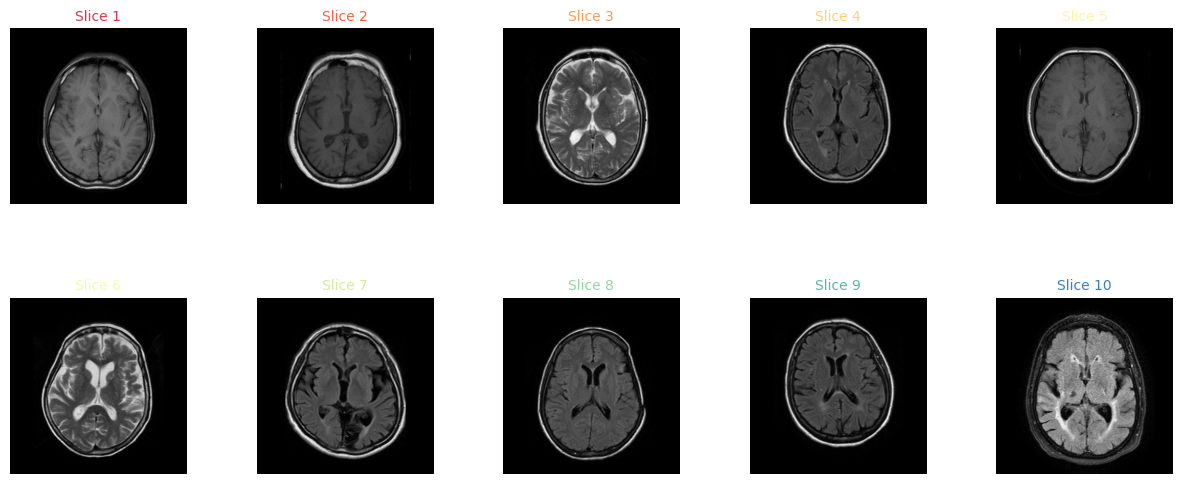

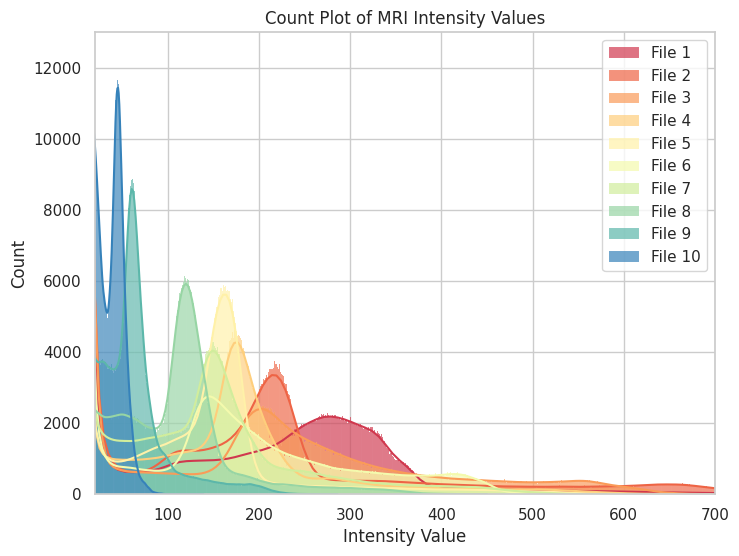

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import SimpleITK as sitk

# Sort the DataFrame by max intensity value
sorted_df = intensity_df.sort_values(by='max_value', ascending=False)

# Create boundaries to sample the indices
boundaries = np.linspace(0, len(sorted_df) - 1, 10, dtype=int)

indices = []
for i in range(len(boundaries) - 1):
    sample_idx = sorted_df.iloc[boundaries[i]:boundaries[i + 1]].sample().index[0]
    indices.append(sample_idx)

sample_idx = sorted_df.iloc[boundaries[-1]:].sample().index[0]
indices.append(sample_idx)

selected_file_paths = intensity_df.file_path.loc[indices]

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

colors = sns.color_palette("Spectral", 10)

for i, ax in enumerate(axs.flatten()):
    path = selected_file_paths.iloc[i]
    reader = sitk.ImageSeriesReader()
    dicom_series = reader.GetGDCMSeriesFileNames(path)
    
    if len(dicom_series) > 0:
        reader.SetFileNames(dicom_series)
        volume = reader.Execute()
        volume_array = sitk.GetArrayFromImage(volume)
        
        # Display the middle slice of the volume with a colored border
        middle_slice = volume_array[volume_array.shape[0] // 2]
        ax.imshow(middle_slice, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Slice {i+1}', fontsize=10, color=colors[i])
        for spine in ax.spines.values():
            spine.set_edgecolor(colors[i])
            spine.set_linewidth(4)
    else:
        print(f"No DICOM files found in {path}")

plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

for i in range(10):
    path = selected_file_paths.iloc[i]
    reader = sitk.ImageSeriesReader()
    dicom_series = reader.GetGDCMSeriesFileNames(path)
    
    if len(dicom_series) > 0:
        reader.SetFileNames(dicom_series)
        volume = reader.Execute()
        volume_array = sitk.GetArrayFromImage(volume).flatten()
        
        # Ensure no inf values are present
        volume_array = np.nan_to_num(volume_array, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Plot the histogram with counts
        sns.histplot(volume_array, kde=True, color=colors[i],discrete=True, stat='count', alpha=0.7, label=f'File {i+1}')
    else:
        print(f"No DICOM files found in {path}")

plt.title('Count Plot of MRI Intensity Values')
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.xlim(20, 700)
plt.ylim(0, 13000)

plt.legend(loc='upper right')
plt.show()


### Variation in these values between scans can lead to differences in signal intensity.

In [9]:
print(f'Modality and Manufacturer Information:\n\tModality(imaging equipment type) : {metadata_df.Modality.unique()[0]}\n\tManufacturer : {metadata_df.Manufacturer.unique()[0]}\n\tManufacturer Model Name : {metadata_df.ManufacturerModelName.unique()[0]}\n')
print(f'Institution Information:\n\tInstitutionbName : {metadata_df.InstitutionName.unique()[0]}\n\tStation Name : {metadata_df.StationName.unique()[0]}\n\t')

Modality and Manufacturer Information:
	Modality(imaging equipment type) : MR
	Manufacturer : Philips Medical Systems
	Manufacturer Model Name : Achieva

Institution Information:
	InstitutionbName : Sepahan Medical Imaging Center
	Station Name : PHILIPS-A9DD1E7
	


In [10]:
metadata_df[['SliceThickness','RepetitionTime','EchoTime','MagneticFieldStrength','SpacingBetweenSlices','EchoTrainLength','PixelBandwidth','ReceiveCoilName','AcquisitionMatrix','FlipAngle','PatientPosition','ImagePositionPatient','ImageOrientationPatient','PixelSpacing','WindowCenter','WindowWidth']].nunique().sort_values()

MagneticFieldStrength          1
PatientPosition                1
ReceiveCoilName                2
FlipAngle                      2
EchoTime                       3
EchoTrainLength                4
PixelSpacing                  15
SpacingBetweenSlices          45
PixelBandwidth                52
AcquisitionMatrix             58
SliceThickness                82
RepetitionTime                95
ImageOrientationPatient     1053
WindowCenter               24834
ImagePositionPatient       26205
WindowWidth                32209
dtype: int64

# Intensity Normalization Methods Test
comparing different normalization techniques applied to MRI intensity values for three subjects. Each histogram reflects the distribution of intensities after applying a specific normalization method.

In [11]:
def min_max_normalization(tensor):
    tensor = torch.flatten(tensor)
    if torch.max(tensor) > torch.min(tensor):
        normalized_value = (tensor - torch.min(tensor)) / (torch.max(tensor) - torch.min(tensor))
    else:
        normalized_value = torch.zeros_like(tensor)
    
    return normalized_value


def z_score(tensor):
    tensor = torch.flatten(tensor)
    if torch.std(tensor) > 0:
        normalized_value = (tensor - torch.mean(tensor)) / torch.std(tensor)
    else:
        normalized_value = torch.zeros_like(tensor)

    return normalized_value

import torch

def percentile_normalization(tensor, lower_percentile=2, upper_percentile=98,method=None):
    tensor = torch.flatten(tensor)
    
    # Calculate the lower and upper percentile values
    lower_value = torch.quantile(tensor, lower_percentile / 100.0)
    upper_value = torch.quantile(tensor, upper_percentile / 100.0)
    
    # Clip the values to be within the percentile range
    tensor_clipped = torch.clamp(tensor, lower_value, upper_value)
    
    if method == 'z-score':
        tensor_clipped = z_score(tensor_clipped)
    elif method == 'min-max':
        tensor_clipped = min_max_normalization(tensor_clipped)
    else:
        pass
    
    return tensor_clipped

def volume(path):
    reader = sitk.ImageSeriesReader()
    dicom_series = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(dicom_series)
    volume = reader.Execute()
    
    return volume

subject_indices = metadata_df['ProtocolName'].iloc[indices[:3]].index
print(metadata_df['ProtocolName'].iloc[indices[:3]])

2106       T1W_SE CLEAR
1538      T2W_TSE SENSE
1410    T2W_FLAIR SENSE
Name: ProtocolName, dtype: object


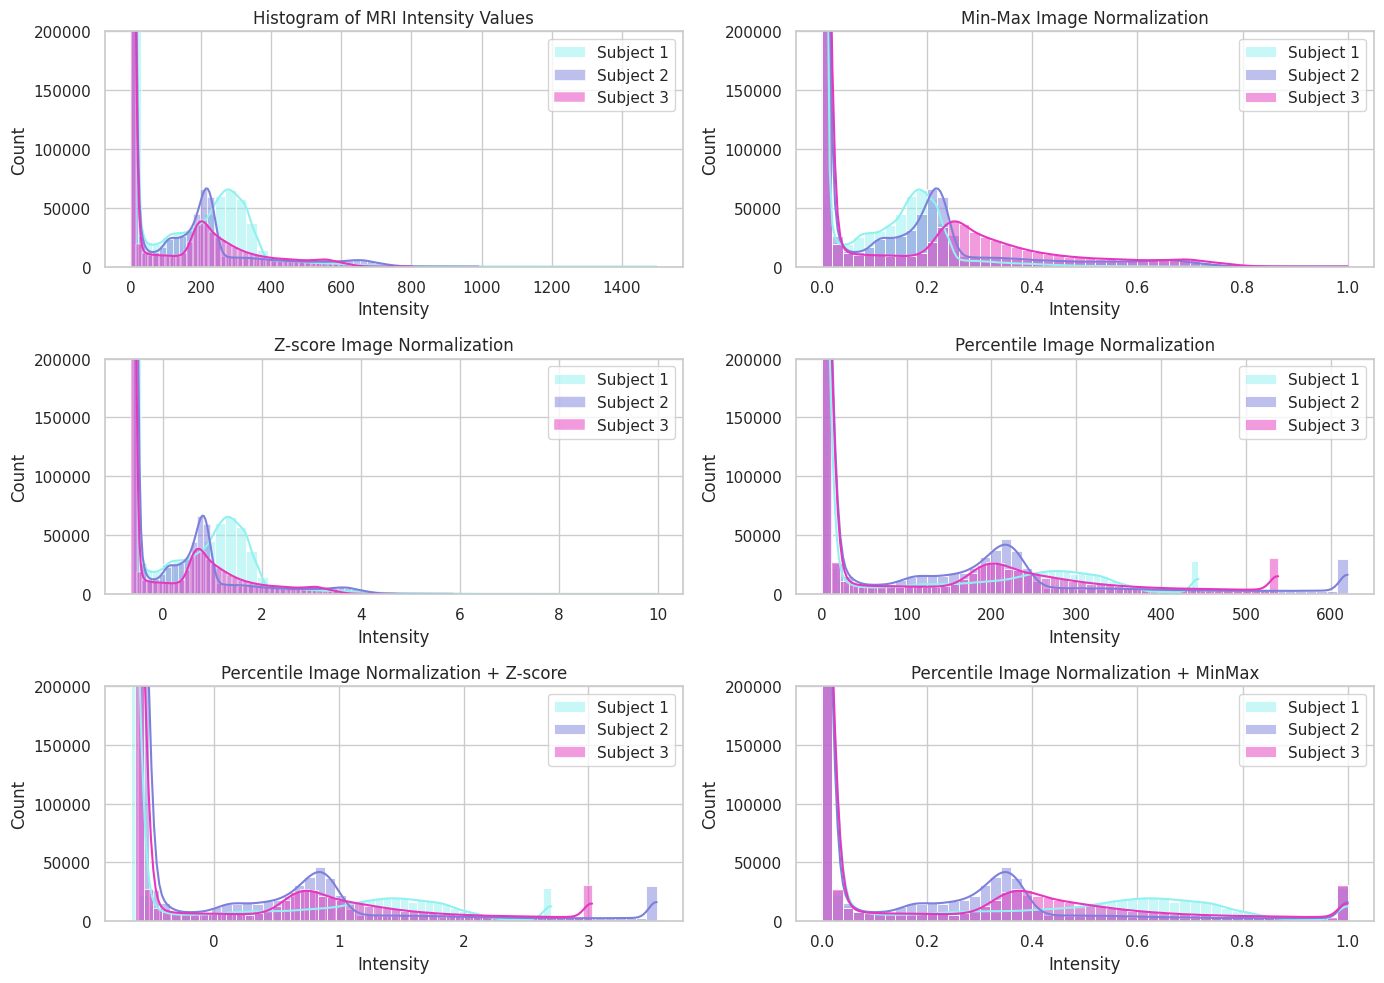

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import SimpleITK as sitk

colors = ['#90F1EF', '#7D80DA', '#E637BF']

# loading data and plotting
def plot_normalized(ax, title, norm_func=None, method=None):
    for i in range(3):
        subject_path = intensity_df['file_path'].iloc[subject_indices[i]]
        subject_tensor = torch.tensor(sitk.GetArrayFromImage(volume(subject_path)), dtype=torch.float32)
        
        # Apply normalization
        if norm_func:
            subject_tensor = norm_func(subject_tensor) if not method else norm_func(subject_tensor, method=method)
        
        sns.histplot(torch.flatten(subject_tensor), bins=50, kde=True, color=colors[i], stat='count', alpha=0.5, label=f'Subject {i+1}', ax=ax)
    
    ax.set_title(title)
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Count')
    ax.set_ylim(0, 200000)
    ax.legend(loc='upper right')


fig, axs = plt.subplots(3, 2, figsize=(14, 10))

# Plotting
plot_normalized(axs[0, 0], 'Histogram of MRI Intensity Values')
plot_normalized(axs[0, 1], 'Min-Max Image Normalization', min_max_normalization)
plot_normalized(axs[1, 0], 'Z-score Image Normalization', z_score)
plot_normalized(axs[1, 1], 'Percentile Image Normalization', percentile_normalization)
plot_normalized(axs[2, 0], 'Percentile Image Normalization + Z-score', percentile_normalization, method='z-score')
plot_normalized(axs[2, 1], 'Percentile Image Normalization + MinMax', percentile_normalization, method='min-max')

plt.tight_layout()
plt.show()


conclusion : Fuck them all!

### Histogram Matching

In [32]:
import torch

def histogram_matching(tensor, reference_tensor, method=None):
    tensor = torch.flatten(tensor)
    reference_tensor = torch.flatten(reference_tensor)

    # Sort both the tensor and the reference tensor
    sorted_tensor, _ = torch.sort(tensor)
    sorted_reference, _ = torch.sort(reference_tensor)

    # Calculate the cumulative distribution function (CDF) of both
    tensor_cdf = torch.cumsum(sorted_tensor, dim=0)
    reference_cdf = torch.cumsum(sorted_reference, dim=0)

    # Normalize CDFs
    tensor_cdf = tensor_cdf / tensor_cdf[-1]
    reference_cdf = reference_cdf / reference_cdf[-1]

    # Perform histogram matching
    indices = torch.searchsorted(reference_cdf, tensor_cdf)
    indices = torch.clamp(indices, max=sorted_reference.size(0) - 1)

    matched_tensor = sorted_reference[indices]
    if method == 'z-score':
        matched_tensor = z_score(matched_tensor)
    elif method == 'min-max':
        matched_tensor = min_max_normalization(matched_tensor)
    else:
        pass

    return matched_tensor.view(tensor.shape)



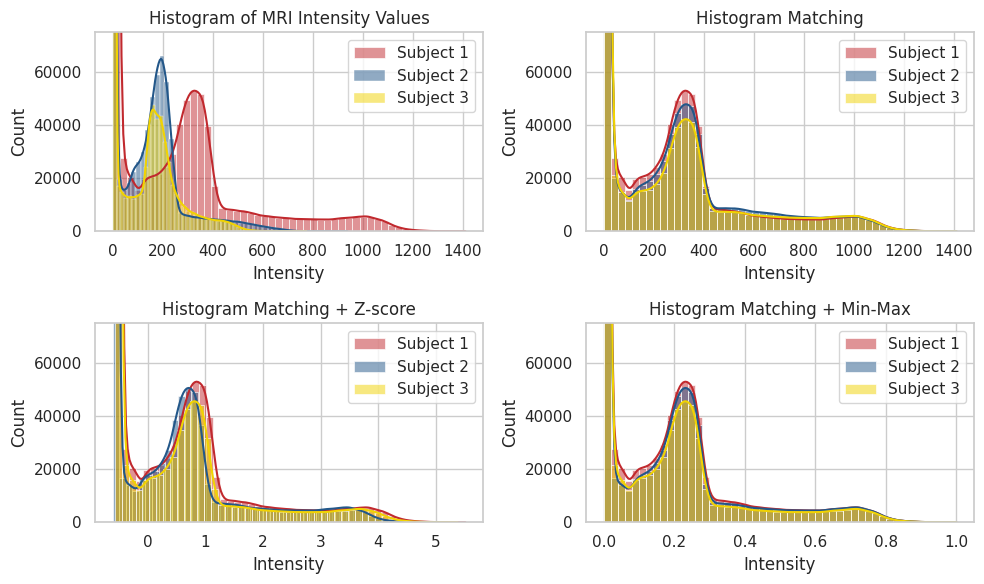

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import SimpleITK as sitk

colors = ['#C1292E', '#235789', '#F1D302']

# Load the reference tensor
reference = torch.tensor(sitk.GetArrayFromImage(volume(intensity_df['file_path'].iloc[subject_indices[0]])), dtype=torch.float32)

# Function to plot normalized histograms
def plot_normalized(ax, title, norm_func=None, reference_tensor=None, method=None):
    for i in range(3):
        subject_path = intensity_df['file_path'].iloc[subject_indices[i]]
        subject_tensor = torch.tensor(sitk.GetArrayFromImage(volume(subject_path)), dtype=torch.float32)
        
        # Apply normalization if a function is provided
        if norm_func:
            if reference_tensor is not None:
                subject_tensor = norm_func(subject_tensor, reference_tensor=reference_tensor)
                if method is not None:
                    subject_tensor = norm_func(subject_tensor, reference_tensor=reference_tensor, method=method)
            else:
                subject_tensor = norm_func(subject_tensor)
        
        # Plot histogram
        sns.histplot(torch.flatten(subject_tensor), bins=50, kde=True, color=colors[i], stat='count', alpha=0.5, label=f'Subject {i+1}', ax=ax)
    
    ax.set_title(title)
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Count')
    ax.set_ylim(0, 75000)
    ax.legend(loc='upper right')

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Plot the histograms
plot_normalized(axs[0,0], 'Histogram of MRI Intensity Values')
plot_normalized(axs[0,1], 'Histogram Matching', histogram_matching,reference)
plot_normalized(axs[1,0], 'Histogram Matching + Z-score',histogram_matching,reference,'z-score')
plot_normalized(axs[1,1], 'Histogram Matching + Min-Max',histogram_matching,reference,'min-max')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


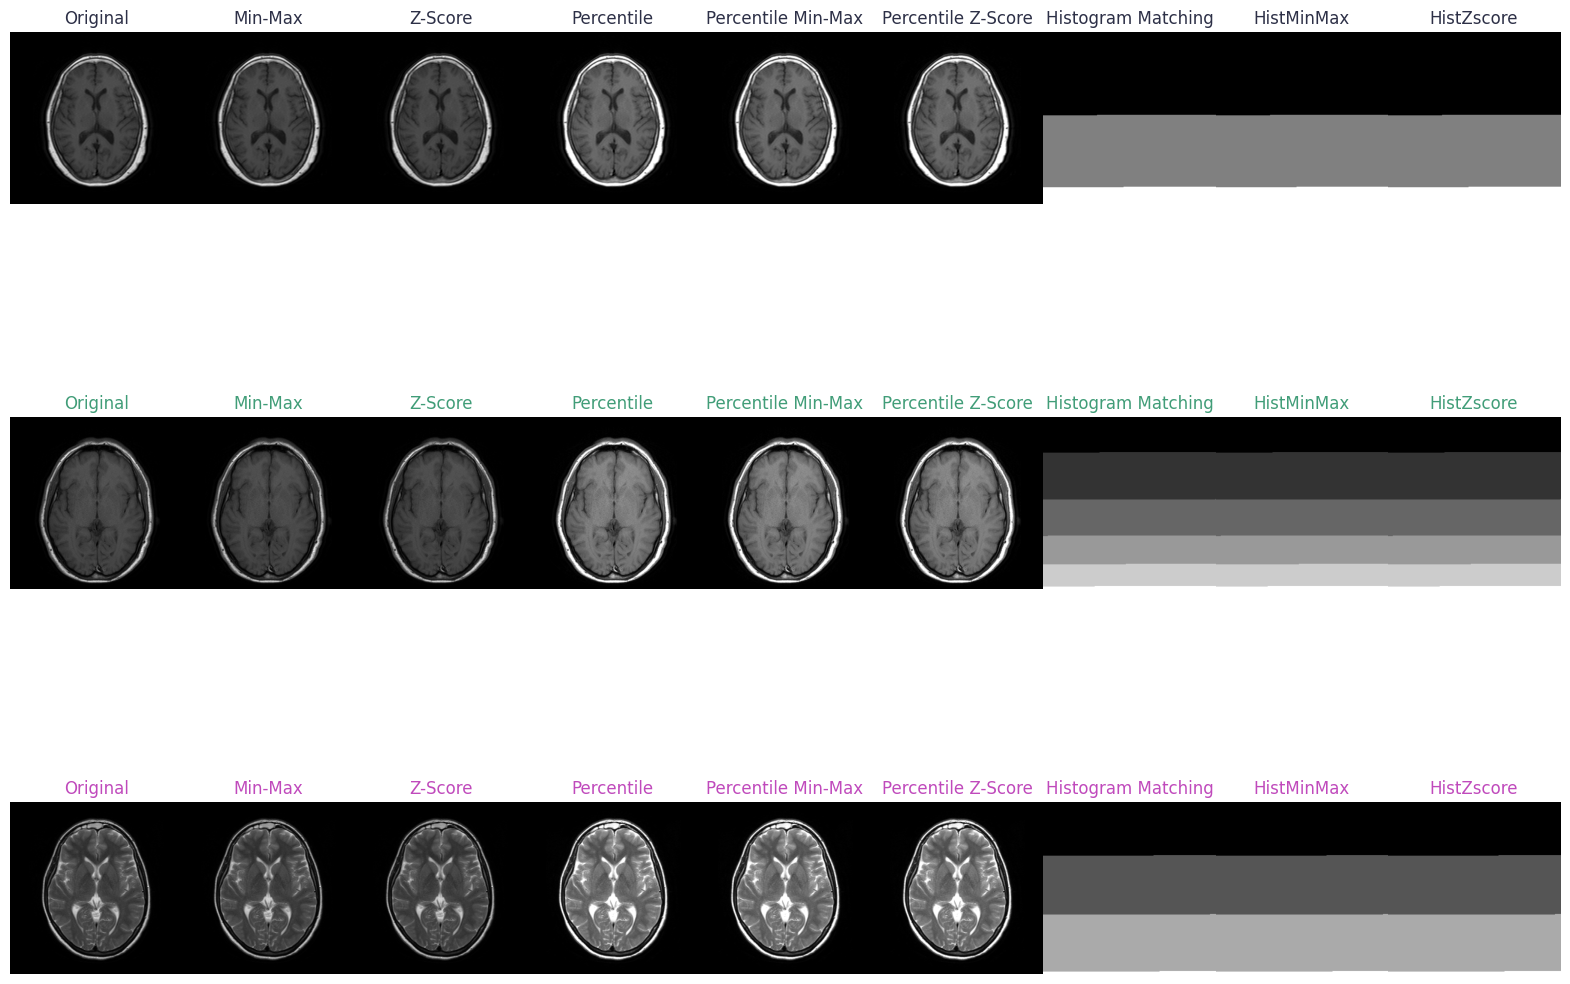

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import SimpleITK as sitk
import numpy as np


def plot_middle_slices(subject_indices,reference):
    fig, axs = plt.subplots(len(subject_indices), 9, figsize=(20, 15))
    colormaps = ['#2D3047','#419D78','#C04ABC']
    plt.subplots_adjust(wspace=0, hspace=0)
    
    
    normalization_methods = {
        "Original": lambda x: x,
        "Min-Max": min_max_normalization,
        "Z-Score": z_score,
        "Percentile": lambda x: percentile_normalization(x, method='percentile'),
        "Percentile Min-Max": lambda x: percentile_normalization(x, method='min-max'),
        "Percentile Z-Score": lambda x: percentile_normalization(x, method='z-score'),
        "Histogram Matching": lambda x: histogram_matching(x,reference),
        "HistMinMax": lambda x: histogram_matching(x,reference, 'min-max'),
        "HistZscore": lambda x: histogram_matching(x,reference, 'z-score')
    }
    
    for i, idx in enumerate(subject_indices):
        subject_path = intensity_df['file_path'].iloc[idx]
        original = torch.tensor(sitk.GetArrayFromImage(volume(subject_path)), dtype=torch.float32)
        
        for j, (method_name, method_func) in enumerate(normalization_methods.items()):
            # Apply normalization
            normalized = method_func(original)  # Apply other normalization methods
            normalized = normalized.reshape(original.shape)
            
            # Extract middle slice
            middle_slice = normalized[normalized.shape[0] // 2].numpy()
            
            # Plot middle slice
            ax = axs[i, j]
            ax.imshow(middle_slice, cmap='gray')
            ax.set_title(f'{method_name}',color=colormaps[i])
            ax.axis('off')
    
    plt.show()

reference = torch.tensor(sitk.GetArrayFromImage(volume(intensity_df['file_path'].iloc[subject_indices[0]])), dtype=torch.float32)
subject_indices = [880,647,91]
plot_middle_slices(subject_indices,reference)


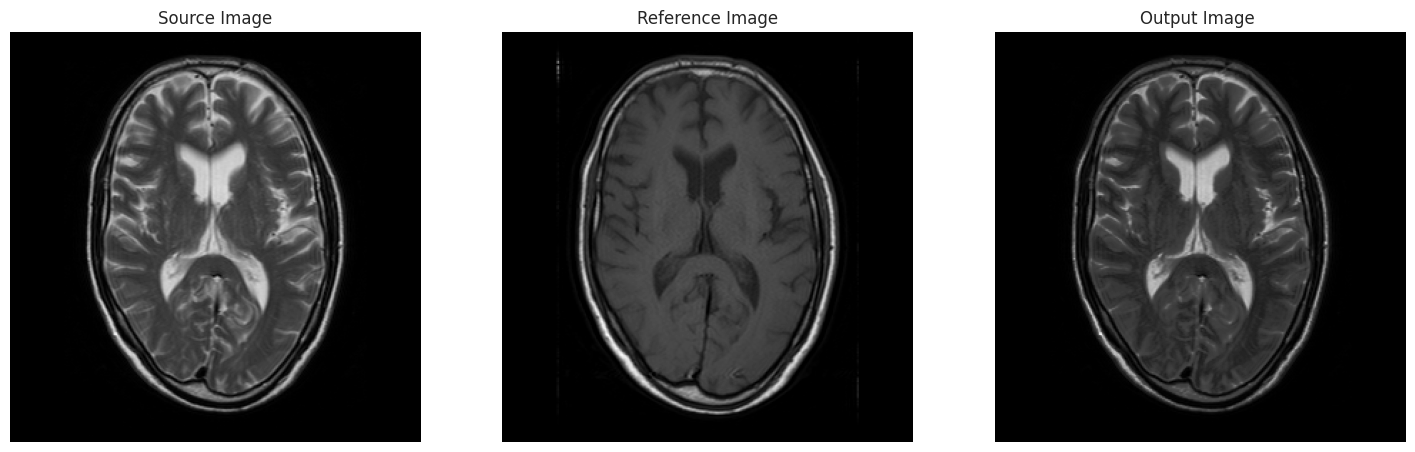

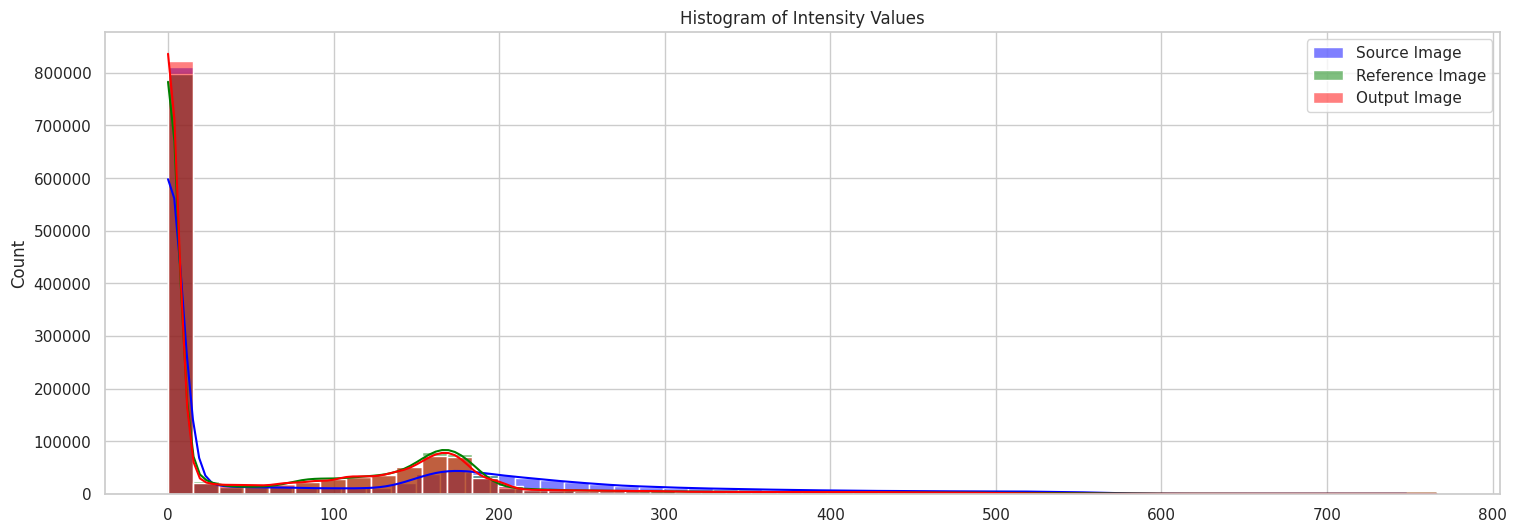

In [34]:
source_image_path = os.path.join(DATA_DIR,'1.3.46.670589.11.10042.5.0.1412.2024020313391873234')
reference_image_path = os.path.join(DATA_DIR,'1.3.46.670589.11.10042.5.0.1412.2024020313401387235')

def dicom_reader(path):
    reader = sitk.ImageSeriesReader()
    image_filenames = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(image_filenames)
    image = reader.Execute()
    
    return image

def middle_slice(image):
    size = image.GetSize()
    middle_index = size[2] // 2
    middle_slice = image[:, :, middle_index]
    
    return middle_slice

source_image = dicom_reader(source_image_path)
reference_image = dicom_reader(reference_image_path)


# Create and configure the Histogram Matching filter
histogram_matcher = sitk.HistogramMatchingImageFilter()
histogram_matcher.SetNumberOfHistogramLevels(256)  
histogram_matcher.SetNumberOfMatchPoints(10)       
histogram_matcher.ThresholdAtMeanIntensityOn()     

output_image = histogram_matcher.Execute(source_image, reference_image)

#Extract and Convert the Middle Slices
source_slice_array = sitk.GetArrayFromImage(middle_slice(source_image))
reference_slice_array = sitk.GetArrayFromImage(middle_slice(reference_image))
output_slice_array = sitk.GetArrayFromImage(middle_slice(output_image))

#Plot the Slices
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(source_slice_array, cmap='gray')
plt.title('Source Image')
plt.axis('off') 

plt.subplot(1, 3, 2)
plt.imshow(reference_slice_array, cmap='gray')
plt.title('Reference Image')
plt.axis('off') 

plt.subplot(1, 3, 3)
plt.imshow(output_slice_array, cmap='gray')
plt.title('Output Image ')
plt.axis('off')  

# Convert the images to arrays for histogram plotting
source_image_array = sitk.GetArrayFromImage(source_image)
reference_image_array = sitk.GetArrayFromImage(reference_image)
output_image_array = sitk.GetArrayFromImage(output_image)


plt.figure(figsize=(18, 6))
sns.histplot(np.ravel(source_image_array), bins=50, kde=True, color='blue', label='Source Image', stat='count', alpha=0.5)
sns.histplot(np.ravel(reference_image_array), bins=50, kde=True, color='green', label='Reference Image', stat='count', alpha=0.5)
sns.histplot(np.ravel(output_image_array), bins=50, kde=True, color='red', label='Output Image', stat='count', alpha=0.5)

plt.legend()
plt.title('Histogram of Intensity Values')
plt.show()

In [40]:
def Histogram_Matcher(source_image, reference_image):
    histogram_matcher = sitk.HistogramMatchingImageFilter()
    histogram_matcher.SetNumberOfHistogramLevels(256)
    histogram_matcher.SetNumberOfMatchPoints(10)
    histogram_matcher.ThresholdAtMeanIntensityOn()
    
    output_image = histogram_matcher.Execute(source_image, reference_image)
    output_image_array = sitk.GetArrayFromImage(output_image)
    return torch.tensor(output_image_array, dtype=torch.float32)

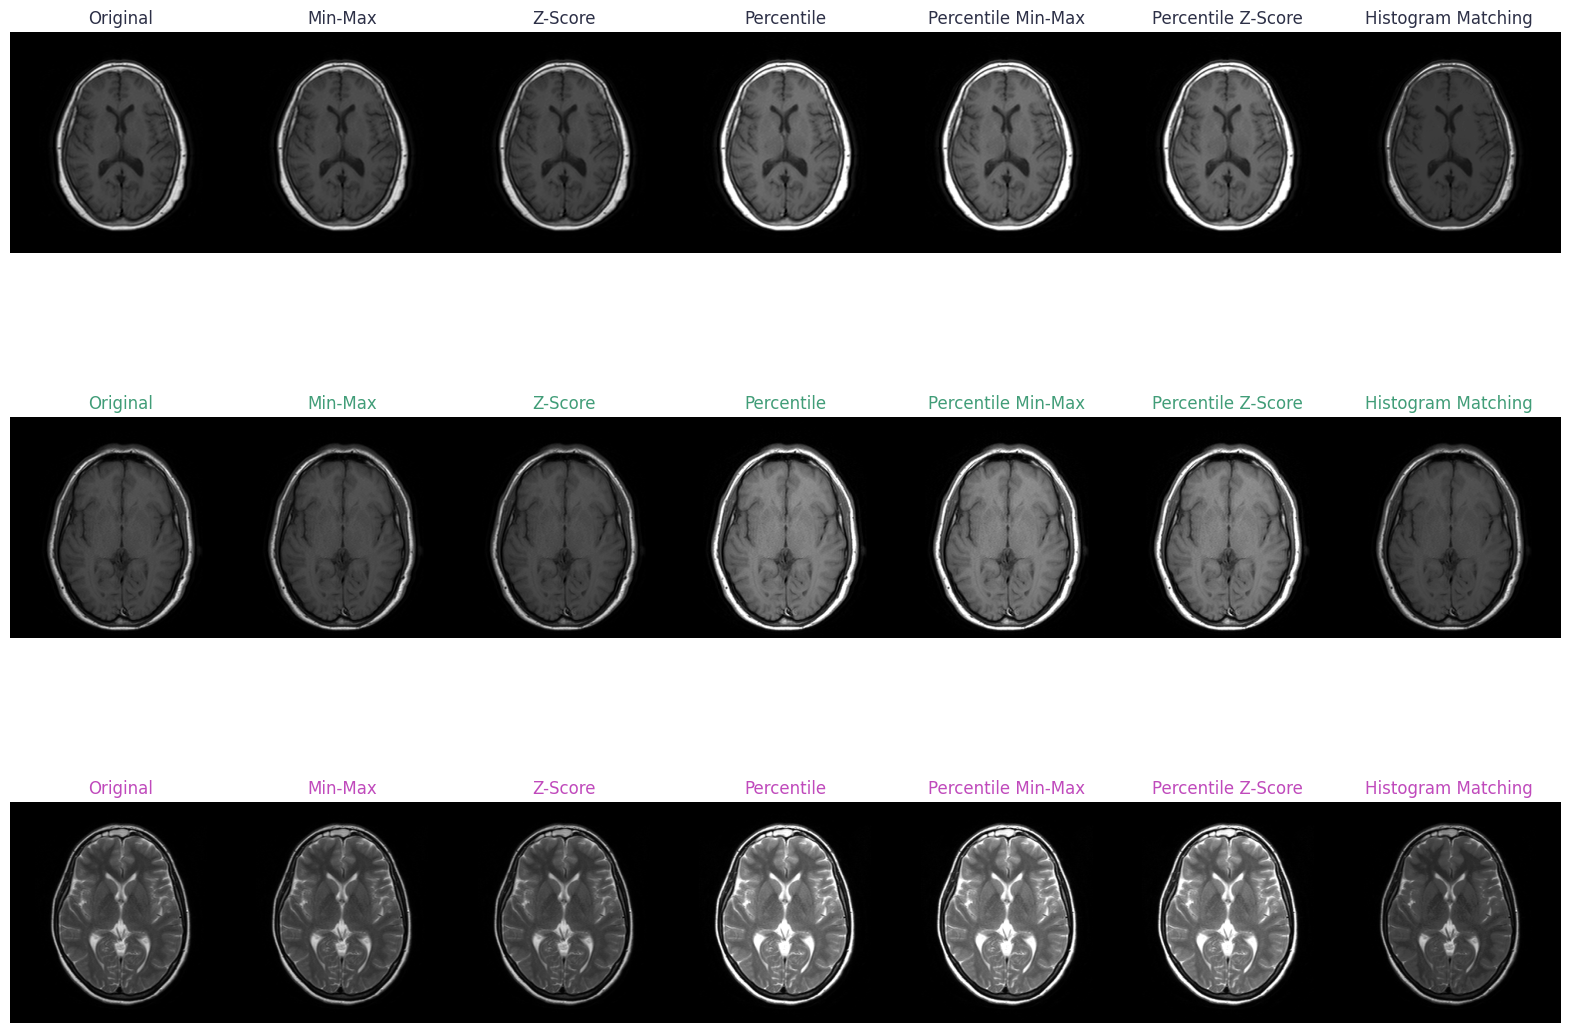

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import SimpleITK as sitk
import numpy as np


def plot_middle_slices(subject_indices,reference):
    fig, axs = plt.subplots(len(subject_indices), 7, figsize=(20, 15))
    colormaps = ['#2D3047','#419D78','#C04ABC']
    plt.subplots_adjust(wspace=0, hspace=0)
    
    
    normalization_methods = {
        "Original": lambda x: x,
        "Min-Max": min_max_normalization,
        "Z-Score": z_score,
        "Percentile": lambda x: percentile_normalization(x, method='percentile'),
        "Percentile Min-Max": lambda x: percentile_normalization(x, method='min-max'),
        "Percentile Z-Score": lambda x: percentile_normalization(x, method='z-score'),
        "Histogram Matching": lambda x: Histogram_Matcher(dicom_reader(x),dicom_reader(reference_image_path)),
    }
    
    for i, idx in enumerate(subject_indices):
        subject_path = intensity_df['file_path'].iloc[idx]
        original = torch.tensor(sitk.GetArrayFromImage(volume(subject_path)), dtype=torch.float32)
        
        for j, (method_name, method_func) in enumerate(normalization_methods.items()):
            # Apply normalization
            if method_name != "Histogram Matching":
                normalized = method_func(original)  
            else:
                normalized = method_func(subject_path)  
                
            normalized = normalized.reshape(original.shape)
            
            # Extract middle slice
            middle_slice = normalized[normalized.shape[0] // 2].numpy()
            
            # Plot middle slice
            ax = axs[i, j]
            ax.imshow(middle_slice, cmap='gray')
            ax.set_title(f'{method_name}',color=colormaps[i])
            ax.axis('off')
    
    plt.show()

subject_indices = [880,647,91]
plot_middle_slices(subject_indices,reference)
